In [0]:
!pip install transformers

     |████████████████████████████████| 2.3MB 2.9MB/s 
     |████████████████████████████████| 368kB 3.4MB/s 
     |████████████████████████████████| 645kB 52.9MB/s 
     |████████████████████████████████| 860kB 39.5MB/s 
     |████████████████████████████████| 1.0MB 27.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.35-cp36-none-any.whl size=883999 sha256=19eabf4397b111b916835f96c0fdb2fd48c720625de7e8150b9e35f62e050121
  Stored in directory: /root/.cache/pip/wheels/63/2a/db/63e2909042c634ef551d0d9ac825b2b0b32dede4a6d87ddc94
Successfully built sacremoses


In [0]:
import os
import gzip
import pickle
import numpy as np
from Bio import SeqIO
from Bio.Data import CodonTable
from matplotlib import pyplot as plt

import torch

from transformers import GPT2Config, GPT2Model, GPT2LMHeadModel

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def check_known_protein(protein_description):
    """filter out hypothetical and putative proteins"""
    is_hypothetical = ('hypoth' in protein_description or 'hetical' in protein_description) # deals with most common misspellings of "hypothetical"
    is_putative = 'putative' in protein_description
    is_known = (not is_hypothetical) and (not is_putative)
    return is_known

def get_CDS_locations(genome_path):
    """exctracts gene locations and seqs from known protein coding genes, only non-hypothetical"""
    gene_loc_list = []
    gene_seq_list = []
    with gzip.open(genome_path, 'rt') as handle: # open file
        for record in SeqIO.parse(handle, "genbank"): # parse each record within file
            feature_list = record.features
            CDS_list = [x for x in feature_list if x.type=='CDS'] # get all CDS features in record
            for CDS in CDS_list:
                try:
                    protein_description = CDS.qualifiers['product'][0]
                    if check_known_protein(protein_description): # only use non-hypothetical proteins
                        gene_loc = CDS.location
                        gene_loc_list.append(gene_loc)

                        gene_seq = CDS.extract(record.seq) # extract locations of CDS
                        gene_seq_list.append(gene_seq)
                except:
                    pass

    return gene_loc_list, gene_seq_list

In [0]:
# all code needed to produce score for "geneness" of amino acid sequence

# mount
from google.colab import drive
drive.mount('/content/drive')
# modeldir = "drive/My Drive/Colab Notebooks/smaug/data/models"
# modeldir = "drive/My Drive/Colab Notebooks/smaug/data/models/10-25-19_morning_20"

# load model
# model = GPT2LMHeadModel.from_pretrained(modeldir).to('cuda')

# modeldir = "drive/My Drive/Colab Notebooks/smaug/data/models/ecoli_trivial"
modeldir = "drive/My Drive/Colab Notebooks/smaug/data/models/ecoli_trivial_length20_overlap10_backup"

model = GPT2LMHeadModel.from_pretrained(modeldir).to('cuda')


# score sequence
def score_seq(aa_seq_string):
    aa_seq_string = aa_seq_string[:40] ################### TODO implement shingles
    
    token = tokenize_aa_seq(aa_seq_string)
    input_ids = token.unsqueeze(0).to('cuda')

    logits = model(input_ids)[0]
    soft = torch.exp(logits)
    softsum = torch.sum(soft, axis=2).view(len(soft),-1,1)
    softproportion = soft/softsum

    predval = torch.roll(torch.argmax(softproportion, axis=2), 1) # remember prediction offset by 1
    
    correctmask = predval == input_ids[:] # why no offset here?
    hardcorrect = torch.sum(correctmask).item()
    totalcorrect = logits.shape[0]*logits.shape[1]

    softcorrect = 0
    for i in range(input_ids.shape[0]):
        for j in range(input_ids.shape[1] - 1): # remember prediction offset by 1
            softcorrect += softproportion[i, j, input_ids[i,j+1]]
    # softcorrect = softcorrect.item()
    softcorrect = softcorrect


    softproportion = softcorrect/totalcorrect 
    hardproportion = hardcorrect/totalcorrect

    return softproportion # hard proportion might work better on long sequences

def tokenize_aa_seq(aa_seq):
    """Convert amino acid letters to integers. Can also use murphy's reduced aa alphabet later"""
    table = {"L":1,
             "V":2,
             "I":3,
             "M":4,
             "C":5,
             "A":6,
             "G":7,
             "S":8,
             "T":9,
             "P":10,
             "F":11,
             "Y":12,
             "W":13,
             "E":14,
             "D":15,
             "N":16,
             "Q":17,
             "K":18,
             "R":19,
             "H":20,
             "X":0, # get rid of these
             "B":0,
             "*":0}
    tokenized = torch.tensor([table[aa] for aa in aa_seq])
    return tokenized

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# load genes and fake ORFs
d = "drive/My Drive/Colab Notebooks/smaug/data"
gene_ORF_path = os.path.join(d, "ecoli_MG1655_geneORFs.pkl")
fake_ORF_path = os.path.join(d, "ecoli_MG1655_fakeORFs.pkl")
# gene_ORF_path = os.path.join(d, "Staphylococcus_geneORFs.pkl")
# fake_ORF_path = os.path.join(d, "Staphylococcus_fakeORFs.pkl")

with open(gene_ORF_path, 'rb') as f:
    gene_aa_filtered = pickle.load(f)
with open(fake_ORF_path, 'rb') as f:
    fake_aa = pickle.load(f)

gene_aa_filtered = [x for x in gene_aa_filtered if len(x) > 40]
# fake_aa = [x for x in fake_aa if len(x) > 40] # already filtered for lenght at creation time

In [0]:
# split long ORFs into shingles
# pad small ORFs with 0s? TODO: implementing this is needed iff shingle_length > minimum ORF size
# goal is to submit scoring to GPU once in parallel, then combine scores later
# remember model was trained on amino acids with 3' to 5' direction, with start and stop codons removed
# also remember current model was trained only on first 40 aa from 3' end
# TODO: retrain model on windows randomly selected from gene


# TODO: this was done in time crunch, should not be done like this. Redo
SHINGLE_STEP = 10
SHINGLE_LENGTH = 20 # shingle length should be the same as trained model window size

ORF_shingled = []
for i, ORFseq in enumerate(gene_aa_filtered):
    if i%1000==0:
        print(i)
    ORF_shingled_temp = []
    while True:
        shingle = ORFseq[:SHINGLE_LENGTH]
        shingle_int = tokenize_aa_seq(shingle)
        ORF_shingled_temp.append(shingle_int)
        if len(ORFseq) > SHINGLE_LENGTH + SHINGLE_STEP:
            ORFseq = ORFseq[SHINGLE_STEP:]
        else:
            break
    shingle_last = ORFseq[-(SHINGLE_LENGTH):]
    shingle_int =  tokenize_aa_seq(shingle_last)
    ORF_shingled_temp.append(shingle_int)
    
    ORF_shingled.append(ORF_shingled_temp)

0
1000
2000
3000


In [0]:
# flatten shingles to submit to GPU
# keep track of which shingles belong to which ORFs
combined = [torch.stack(x, dim=0) for x in ORF_shingled]
combined_shape = [len(x) for x in combined]

combined_flat = torch.cat(combined, dim=0)

In [0]:
# use GPU model to score ORFs
BATCH_SIZE = 2000 # limited by vram

softcorrect_all = []
hardcorrect_all = []

for i in range(0, len(combined_flat), BATCH_SIZE):
    print(i, "of", len(combined_flat))

    input_ids = combined_flat[i:i+BATCH_SIZE].to('cuda')

    logits = model(input_ids)[0]
    soft = torch.exp(logits)
    softsum = torch.sum(soft, axis=2).view(len(soft),-1,1)
    softproportion = soft/softsum

    predval = torch.roll(torch.argmax(softproportion, axis=2), 1) # remember prediction offset by 1

    correctmask = predval == input_ids
    hardcorrect = torch.sum(correctmask, axis=1)
    hardcorrect_list = [int(x) for x in hardcorrect]
    totalcorrect = logits.shape[1] # should be equal to shingle length

    softcorrect_list = []
    for i in range(input_ids.shape[0]):
        softcorrect = 0
        for j in range(input_ids.shape[1] - 1): # remember prediction offset by 1
            softcorrect += softproportion[i, j, input_ids[i,j+1]]/logits.shape[1]
        softcorrect_list.append(softcorrect.item())

    softcorrect_all.extend(softcorrect_list)
    hardcorrect_all.extend(hardcorrect_list)

0 of 106480
2000 of 106480
4000 of 106480
6000 of 106480
8000 of 106480
10000 of 106480
12000 of 106480
14000 of 106480
16000 of 106480
18000 of 106480
20000 of 106480
22000 of 106480
24000 of 106480
26000 of 106480
28000 of 106480
30000 of 106480
32000 of 106480
34000 of 106480
36000 of 106480
38000 of 106480
40000 of 106480
42000 of 106480
44000 of 106480
46000 of 106480
48000 of 106480
50000 of 106480
52000 of 106480
54000 of 106480
56000 of 106480
58000 of 106480
60000 of 106480
62000 of 106480
64000 of 106480
66000 of 106480
68000 of 106480
70000 of 106480
72000 of 106480
74000 of 106480
76000 of 106480
78000 of 106480
80000 of 106480
82000 of 106480
84000 of 106480
86000 of 106480
88000 of 106480
90000 of 106480
92000 of 106480
94000 of 106480
96000 of 106480
98000 of 106480
100000 of 106480
102000 of 106480
104000 of 106480
106000 of 106480


In [0]:
# recombine scores, normalize by length in log space
scores_GENE = []
i = 0
for l in combined_shape:
    scores = softcorrect_all[i:i+l]
    # scores = hardcorrect_all[i:i+l]
    i += l

    scorelogs = np.log(scores)
    score = np.exp(np.mean(scorelogs))
    scores_GENE.append(score)

In [0]:
# split long ORFs into shingles
# pad small ORFs with 0s? TODO: implementing this is needed iff shingle_length > minimum ORF size
# goal is to submit scoring to GPU once in parallel, then combine scores later
# remember model was trained on amino acids with 3' to 5' direction, with start and stop codons removed
# also remember current model was trained only on first 40 aa from 3' end
# TODO: retrain model on windows randomly selected from gene


# TODO: this was done in time crunch, should not be done like this. Redo
SHINGLE_STEP = 10
SHINGLE_LENGTH = 20 # shingle length should be the same as trained model window size

ORF_shingled = []
for i, ORFseq in enumerate(fake_aa):
    if i%10000==0:
        print(i)
    ORF_shingled_temp = []
    while True:
        shingle = ORFseq[:SHINGLE_LENGTH]
        shingle_int = tokenize_aa_seq(shingle)
        ORF_shingled_temp.append(shingle_int)
        if len(ORFseq) > SHINGLE_LENGTH + SHINGLE_STEP:
            ORFseq = ORFseq[SHINGLE_STEP:]
        else:
            break
    shingle_last = ORFseq[-(SHINGLE_LENGTH):]
    shingle_int =  tokenize_aa_seq(shingle_last)
    ORF_shingled_temp.append(shingle_int)
    
    ORF_shingled.append(ORF_shingled_temp)

0
10000
20000


In [0]:
# flatten shingles to submit to GPU
# keep track of which shingles belong to which ORFs
combined = [torch.stack(x, dim=0) for x in ORF_shingled]
combined_shape_arf = [len(x) for x in combined]

combined_flat = torch.cat(combined, dim=0)

In [0]:
# use GPU model to score fake ORFs
BATCH_SIZE = 1000 # limited by vram

softcorrect_all_arf = []
hardcorrect_all_arf = []

for i in range(0, len(combined_flat), BATCH_SIZE):
    print(i, "of", len(combined_flat))

    input_ids = combined_flat[i:i+BATCH_SIZE].to('cuda')

    logits = model(input_ids)[0]
    soft = torch.exp(logits)
    softsum = torch.sum(soft, axis=2).view(len(soft),-1,1)
    softproportion = soft/softsum

    predval = torch.roll(torch.argmax(softproportion, axis=2), 1) # remember prediction offset by 1

    correctmask = predval == input_ids
    hardcorrect = torch.sum(correctmask, axis=1)
    hardcorrect_list = [int(x) for x in hardcorrect]
    totalcorrect = logits.shape[1] # should be equal to shingle length

    softcorrect_list = []
    for i in range(input_ids.shape[0]):
        softcorrect = 0
        for j in range(input_ids.shape[1] - 1): # remember prediction offset by 1
            softcorrect += softproportion[i, j, input_ids[i,j+1]]/logits.shape[1]
        softcorrect_list.append(softcorrect.item())

    softcorrect_all_arf.extend(softcorrect_list)
    hardcorrect_all_arf.extend(hardcorrect_list)

0 of 183259
1000 of 183259
2000 of 183259
3000 of 183259
4000 of 183259
5000 of 183259
6000 of 183259
7000 of 183259
8000 of 183259
9000 of 183259
10000 of 183259
11000 of 183259
12000 of 183259
13000 of 183259
14000 of 183259
15000 of 183259
16000 of 183259
17000 of 183259
18000 of 183259
19000 of 183259
20000 of 183259
21000 of 183259
22000 of 183259
23000 of 183259
24000 of 183259
25000 of 183259
26000 of 183259
27000 of 183259
28000 of 183259
29000 of 183259
30000 of 183259
31000 of 183259
32000 of 183259
33000 of 183259
34000 of 183259
35000 of 183259
36000 of 183259
37000 of 183259
38000 of 183259
39000 of 183259
40000 of 183259
41000 of 183259
42000 of 183259
43000 of 183259
44000 of 183259
45000 of 183259
46000 of 183259
47000 of 183259
48000 of 183259
49000 of 183259
50000 of 183259
51000 of 183259
52000 of 183259
53000 of 183259
54000 of 183259
55000 of 183259
56000 of 183259
57000 of 183259
58000 of 183259
59000 of 183259
60000 of 183259
61000 of 183259
62000 of 183259
63000

In [0]:
# recombine scores, normalize by length in log space
scores_ARF = []
i = 0
for l in combined_shape_arf:
    scores = softcorrect_all_arf[i:i+l]
    # scores = hardcorrect_all_arf[i:i+l]
    i += l

    scorelogs = np.log(scores)
    score = np.exp(np.mean(scorelogs))
    scores_ARF.append(score)

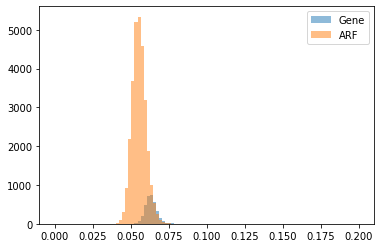

In [0]:
bins = np.linspace(0, 0.2, 100)
plt.hist(scores_GENE, bins, alpha=0.5, label="Gene")
plt.hist(scores_ARF, bins, alpha=0.5, label="ARF")
plt.legend(loc='upper right')
plt.show()

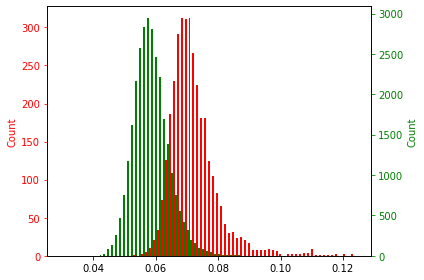

In [0]:
#https://stackoverflow.com/questions/6871201/plot-two-histograms-at-the-same-time-with-matplotlib
#sets up the axis and gets histogram data
colors = ["red", "green"]

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.hist([scores_GENE, scores_ARF], color=colors)
n, bins, patches = ax1.hist([scores_GENE,scores_ARF], bins=75, range=[0.03,0.125])
ax1.cla() #clear the axis

#plots the histogram data
width = (bins[1] - bins[0]) * .5
bins_shifted = bins + width
ax1.bar(bins[:-1], n[0], width, align='edge', color=colors[0])
ax2.bar(bins_shifted[:-1], n[1], width, align='edge', color=colors[1])

#finishes the plot
ax1.set_ylabel("Count", color=colors[0])
ax2.set_ylabel("Count", color=colors[1])
ax1.tick_params('y', colors=colors[0])
ax2.tick_params('y', colors=colors[1])
plt.tight_layout()
plt.show()

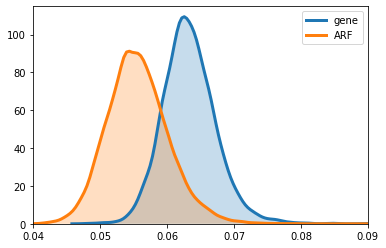

In [0]:
import seaborn as sns
sns.distplot(scores_GENE, hist = False, kde = True,
             kde_kws = {'shade': True, 'linewidth': 3}, 
             label = 'gene')
sns.distplot(scores_ARF, hist = False, kde = True,
             kde_kws = {'shade': True, 'linewidth': 3}, 
             label = 'ARF')
plt.xlim([0.04,0.09])
plt.show()